In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.image import imread
from pathlib import Path
from skimage.io import imread
from PIL import Image
from typing import Union, Tuple

#------ALL FUNCTIONS NEEDED------


# Wienerfilter
def local_wiener_filter_fast(image, window_size=5, noise_variance=None):
    """
    Vectorized version of the local Wiener filter, matching the looped version's output.
    """
    image = image.astype(np.float64)

    # 1) Estimate global noise variance
    if noise_variance is None:
        noise_variance = np.var(image - np.mean(image))

    # 2) Pad image explicitly like in the looped version
    pad = window_size // 2
    img_padded = np.pad(image, pad, mode='reflect')

    # 3) Compute local mean and variance with uniform filters
    local_mean = uniform_filter(img_padded, window_size)[pad:-pad, pad:-pad]
    local_sq_mean = uniform_filter(img_padded**2, window_size)[pad:-pad, pad:-pad]
    local_var = local_sq_mean - local_mean**2

    # 4) Wiener filter formula
    gain = np.zeros_like(image)
    mask = local_var > noise_variance
    gain[mask] = (local_var[mask] - noise_variance) / local_var[mask]
    result = local_mean + gain * (image - local_mean)

    return result

# creating histogram for Otsu threshholding  
def custom_histogram(image: np.ndarray, nbins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the histogram and corresponding bin centers of a grayscale image,
    replicating the behavior of skimage.exposure.histogram, including normalization
    to the [0, 255] range. This ensures consistent behavior with Otsu implementations
    that assume 8-bit images.

    Args:
        image (np.ndarray): Input image as a 2D array of grayscale values.
        nbins (int): Number of bins for the histogram (default: 256).

    Returns:
        hist (np.ndarray): Array of histogram frequencies for each bin.
        bin_centers (np.ndarray): Array of bin center values.
    """
    # Determine the minimum and maximum pixel intensity in the image
    img_min, img_max = image.min(), image.max()

    # Normalize the image intensities to the range [0, 255], as in skimage
    image_scaled = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)

    # Compute the histogram of the scaled image within [0, 255]
    hist, bin_edges = np.histogram(
        image_scaled.ravel(),
        bins=nbins,
        range=(0, 255)
    )

    # Compute bin centers as the average of adjacent bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return hist, bin_centers

# Otsu thresholding
def apply_global_otsu(image: np.ndarray) -> float:
    """
    Computes the global Otsu threshold of an input grayscale image in a way that matches
    the behavior of skimage.filters.threshold_otsu, including histogram scaling and
    threshold rescaling back to the original intensity range.

    This function enables nearly identical thresholding results to skimage's implementation,
    even on images with floating-point or non-8-bit integer data.

    Args:
        image (np.ndarray): Input image as a 2D array of grayscale values.

    Returns:
        threshold_original (float): Computed Otsu threshold mapped back to the original image range.
    """
    # Compute histogram and bin centers consistent with skimage
    hist, bin_centers = custom_histogram(image, nbins=256)
    hist = hist.astype(np.float64)

    # Normalize histogram to obtain probability distribution p(k)
    p = hist / hist.sum()

    # Compute cumulative sums of class probabilities ω0 and ω1
    omega0 = np.cumsum(p)                           # Class probabilities for background
    omega1 = np.cumsum(p[::-1])[::-1]               # Class probabilities for foreground

    # Compute cumulative sums of class means μ0 and μ1
    mu0 = np.cumsum(p * bin_centers)                # Class means for background
    mu1 = np.cumsum((p * bin_centers)[::-1])[::-1]  # Class means for foreground

    # Compute between-class variance σ_b^2 for each possible threshold
    sigma_b_squared = (omega0[:-1] * omega1[1:] * (mu0[:-1] / omega0[:-1] - mu1[1:] / omega1[1:])**2)

    # Find the threshold index t maximizing σ_b^2
    t_idx = np.argmax(sigma_b_squared)
    t_scaled = bin_centers[t_idx]

    # Rescale threshold t back to original image intensity range
    img_min, img_max = image.min(), image.max()
    t_original = t_scaled / 255 * (img_max - img_min) + img_min

    return (image > t_original).astype(np.uint8)

# Dice score
def dice_score(otsu_img, otsu_gt):

    # control if the Pictures have the same Size
    if len(otsu_img) != len(otsu_gt):
       if len(otsu_img) > len(otsu_gt):
         otsu_img = otsu_img[1:len(otsu_gt)]
       else:
        otsu_gt = otsu_gt[1:len(otsu_img)]


    # defining the variables for the Dice Score equation
    positive_overlap = 0
    sum_img = 0
    sum_gt = 0

    for t, p in zip(otsu_img, otsu_gt):
        if t == 1:
            sum_img += 1
        if p == 1:
            sum_gt += 1
        if t == 1 and p == 1:
            positive_overlap += 1

    if sum_img + sum_gt == 0:
        return 1.0

    return 2 * positive_overlap / (sum_img + sum_gt)

# Process single image and its groundtruth
def process_single(img_path: Path, gt_path: Path, s) -> float:
    """ 
    Reads one image and corresponding groundtruth, proccesses, segments and computes dice score for one image.
    """
    # Reads image and reads, binarizes groundtruth
    img = imread(img_path, as_gray=True)
    img_scaled  = (img / img.max() * 255).astype('uint8')
    gt = imread(gt_path, as_gray=True)
    gt  = 1 - (gt == 0)         

    # Wienerfilter based background estimation and removal
    bg = local_wiener_filter_fast(img, window_size=s)
    img_filtered = img - bg
    

    # 1nd Otsu
    binary1 = apply_global_otsu(img_filtered)

    if np.mean(binary1)>0.5:
        binary1 = ~binary1

    # 5. Compute Dice score
    return dice_score(binary1.flatten(), gt.flatten())

# -------------------------------------------------------------------
# Mainroutine: Going through all image-gt pairs and collect all dice scores of data set: NIH3T3
# -------------------------------------------------------------------

# Define window sizes to test (e.g., from 3 to 21 in steps of 2)
window_sizes = np.arange(149, 253, 2)

# Set paths
img_dir = Path("data/NIH3T3/img")
gt_dir  = Path("data/NIH3T3/gt")

# Loop over window sizes
dice_score_means_NIH3T3 = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("dna-*.png")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"{idx}.png"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_NIH3T3.append(dice_score_mean)

np.save('NIH3T3_dice_means_wien', dice_score_means_NIH3T3)
    
# NEXT

# Set paths
img_dir = Path("data/N2DL-HeLa/img")
gt_dir  = Path("data/N2DL-HeLa/gt")

# Loop over window sizes
dice_score_means_N2DL_HeLa = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("t-*.tif")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"man_seg{idx}.tif"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_N2DL_HeLa.append(dice_score_mean)

np.save('N2DL-HeLa_dice_means_wien', dice_score_means_N2DL_HeLa)


# NEXT

# Set paths
img_dir = Path("data/N2DH-GOWT1/img")
gt_dir  = Path("data/N2DH-GOWT1/gt")

# Loop over gamma values
dice_score_means_N2DH_GOWT1 = []

for size in window_sizes:
    dice_scores = []

    for img_file in sorted(img_dir.glob("t-*.tif")):
        idx = img_file.stem.split('-')[-1]
        gt_file = gt_dir / f"man_seg{idx}.tif"

        # Compute Dice score for current image and window size
        score = process_single(img_file, gt_file, s=size)
        dice_scores.append(score)

    # Convert to numpy array and print mean
    dice_scores = np.array(dice_scores)
    dice_score_mean = np.mean(dice_scores)
    print(f"wien {size:.2f} → Mean Dice: {dice_scores.mean():.4f}")
    dice_score_means_N2DH_GOWT1.append(dice_score_mean)

np.save('N2DH-GOWT1_dice_means_wien', dice_score_means_N2DH_GOWT1)

wien 149.00 → Mean Dice: 0.7988
wien 151.00 → Mean Dice: 0.7979
wien 153.00 → Mean Dice: 0.7999
wien 155.00 → Mean Dice: 0.8002
wien 157.00 → Mean Dice: 0.8010
wien 159.00 → Mean Dice: 0.8024
wien 161.00 → Mean Dice: 0.8026
wien 163.00 → Mean Dice: 0.8020
wien 165.00 → Mean Dice: 0.8035
wien 167.00 → Mean Dice: 0.8022
wien 169.00 → Mean Dice: 0.8040
wien 171.00 → Mean Dice: 0.8022
wien 173.00 → Mean Dice: 0.8023
wien 175.00 → Mean Dice: 0.8028
wien 177.00 → Mean Dice: 0.8047
wien 179.00 → Mean Dice: 0.8036
wien 181.00 → Mean Dice: 0.8025
wien 183.00 → Mean Dice: 0.8028
wien 185.00 → Mean Dice: 0.8032
wien 187.00 → Mean Dice: 0.8042
wien 189.00 → Mean Dice: 0.8043
wien 191.00 → Mean Dice: 0.8056
wien 193.00 → Mean Dice: 0.8051
wien 195.00 → Mean Dice: 0.8053
wien 197.00 → Mean Dice: 0.8062
wien 199.00 → Mean Dice: 0.8065
wien 201.00 → Mean Dice: 0.8068
wien 203.00 → Mean Dice: 0.8052
wien 205.00 → Mean Dice: 0.8053
wien 207.00 → Mean Dice: 0.8057
wien 209.00 → Mean Dice: 0.8044
wien 211

Optimal window size: 201.00 Mean dice = 0.7431


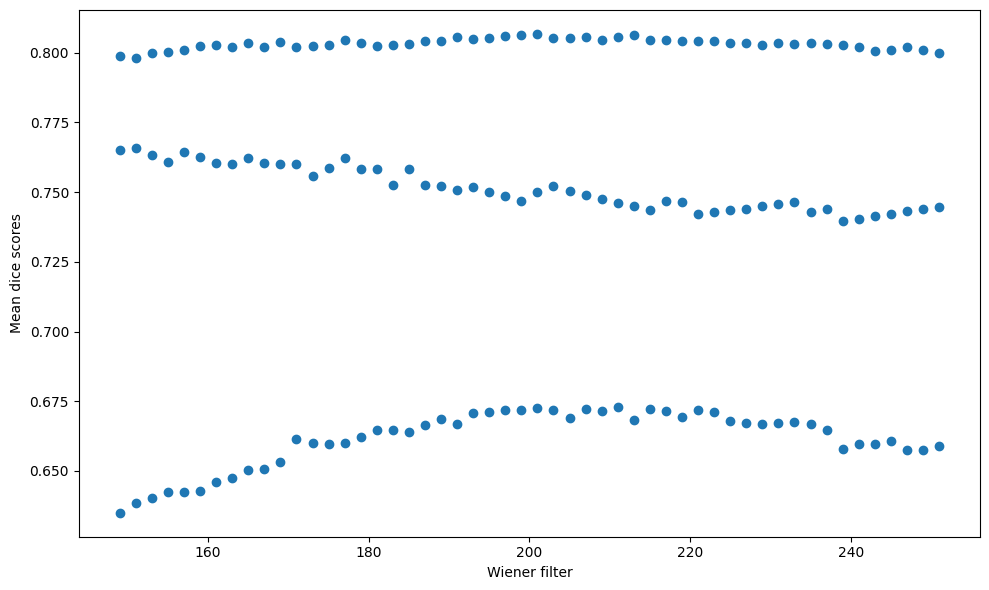

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
#PLOT FOR mean dice score in dependency of window size
#------------------------------------------------------


# Define indices for the labels of the later x-axis 
window_sizes = np.arange(149, 253, 2)

x = np.concatenate((window_sizes, window_sizes, window_sizes))

# Load the Dice scores from Otsu-only into one array, and those from gamma-transformation into another
# Loading

NIH3T3_dice = np.load('NIH3T3_dice_means_wien.npy')
N2DL_HeLa_dice = np.load('N2DL-HeLa_dice_means_wien.npy')
N2DH_GOWT1_dice = np.load('N2DH-GOWT1_dice_means_wien.npy')



# Combining
all_dice_means_wiener = np.concatenate((NIH3T3_dice, N2DL_HeLa_dice, N2DH_GOWT1_dice))

# Find the best window size

# Combine all vectors into 2d array (Columns: the datasets, rows: the window size)
all_means = np.vstack([NIH3T3_dice, N2DL_HeLa_dice, N2DH_GOWT1_dice]).T

# Calculate the mean of each gamma value across all datasets (mean of rows)
mean_across_datasets = all_means.mean(axis=1)  # shape = (len(gamma_values),)

# Find the index of the maximum row mean
best_idx = np.argmax(mean_across_datasets)

# Use index to find the best gamma value
best_gamma = window_sizes[best_idx]
best_dice  = mean_across_datasets[best_idx]

print(f"Optimal window size: {best_gamma:.2f} Mean dice = {best_dice:.4f}")



# Create scatter plot
plt.figure(figsize=(10,6))
plt.scatter(x, all_dice_means_wiener)

plt.xlabel('Wiener filter')
plt.ylabel('Mean dice scores')
plt.title('')
plt.tight_layout()
plt.show()

In [15]:
import os
import sys
import numpy as np
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from scipy.ndimage import uniform_filter

# Current folder as project_root
# Going three layers of folders upwards to src
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
src_dir      = os.path.join(project_root)

# Add the src directory to the Python module search path
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import importlib
import src.Dice_Score
importlib.reload(src.Dice_Score)


from src.Complete_Otsu_Global import otsu_threshold_skimage_like
from src.Dice_Score import dice_score
from src.imread_all import (
    load_nih3t3_images,
    load_n2dl_hela_images,
    load_n2dh_gowt1_images,
)

# Wienerfilter
def local_wiener_filter_fast(image, window_size=5, noise_variance=None):
    """
    Vectorized version of the local Wiener filter, matching the looped version's output.
    """
    image = image.astype(np.float64)

    # 1) Estimate global noise variance
    if noise_variance is None:
        noise_variance = np.var(image - np.mean(image))

    # 2) Pad image explicitly like in the looped version
    pad = window_size // 2
    img_padded = np.pad(image, pad, mode='reflect')

    # 3) Compute local mean and variance with uniform filters
    local_mean = uniform_filter(img_padded, window_size)[pad:-pad, pad:-pad]
    local_sq_mean = uniform_filter(img_padded**2, window_size)[pad:-pad, pad:-pad]
    local_var = local_sq_mean - local_mean**2

    # 4) Wiener filter formula
    gain = np.zeros_like(image)
    mask = local_var > noise_variance
    gain[mask] = (local_var[mask] - noise_variance) / local_var[mask]
    result = local_mean + gain * (image - local_mean)

    return result

def calculate_dice_scores_wienerfilter_global(imgs, gts, s):
    """
    Process all images and corresponding ground truths to compute a list of Dice scores.

    Args:
        imgs (list of np.ndarray): Grayscale input images.
        gts (list of np.ndarray): Corresponding ground-truth masks.

    Returns:
        dice_scores (list of float): Dice scores for each image-groundtruth pair.
    """
    dice_scores = []

    for img, gt in zip(imgs, gts):
        
        # binarize groundtruth
        gt_bin = 1 - ((gt / gt.max()) == 0)

        # wiener filter background estimation and removal
        bg= local_wiener_filter_fast(img, window_size=s)
        img_filtered = img-bg


        # global otsu thresholding
        t = otsu_threshold_skimage_like(img_filtered)
        binary1 = (img_filtered > t)

        # invert if necessary
        if np.mean(binary1) > 0.5:
            binary1= ~binary1

        # calculate dice score
        score = dice_score(binary1.flatten(), gt_bin.flatten())
        dice_scores.append(score)

    return dice_scores

# Generic evaluation across datasets and window sizes
def evaluate_datasets_wiener_filter(
    datasets, window_sizes: np.ndarray, output_dir: Path = Path('Dice_scores')
) -> dict:
    """
    Runs evaluation for multiple datasets and window sizes,
    returns dictionary of mean Dice arrays keyed by dataset name.
    """
    output_dir.mkdir(exist_ok=True)
    results = {}

    for name, loader in datasets:
        imgs, gts, img_paths, gt_paths = loader(base_path=os.path.join(project_root, 'data-git', name))
        means = []
        print(f"=== Processing {name} ===")
        for s in window_sizes:

         scores = calculate_dice_scores_wienerfilter_global(imgs, gts, s)
         mean_score = float(np.mean(scores))
         print(f"window {s:2d} → Mean Dice: {mean_score:.4f}")
         means.append(mean_score)
        results[name] = np.array(means)
        np.save(output_dir / f"{name}_dice_means_wienerfilter.npy", results[name])
        print(f"Saved {name} results to {output_dir / f'{name}_dice_means_wienerfilter.npy'}\n")

    # Combine into table: rows=window_sizes, cols=datasets order
    table = np.vstack([results[name] for name, _ in datasets]).T
    np.save(output_dir / "all_datasets_dice_means_wienerfilter.npy", table)
    print(f"Saved combined table to {output_dir / 'all_datasets_dice_means_wienerfilter.npy'}")
    return results

if __name__ == '__main__':
    # Define window sizes (odd sizes)
    window_sizes = np.arange(3, 301, 2)
    datasets = [
        ('NIH3T3', load_nih3t3_images),
        ('N2DL-HeLa', load_n2dl_hela_images),
        ('N2DH-GOWT1', load_n2dh_gowt1_images),
    ]

    results = evaluate_datasets_wiener_filter(datasets, window_sizes)




=== Processing NIH3T3 ===
window  3 → Mean Dice: 0.2797
window  5 → Mean Dice: 0.2811
window  7 → Mean Dice: 0.2847
window  9 → Mean Dice: 0.2842
window 11 → Mean Dice: 0.2818
window 13 → Mean Dice: 0.2905
window 15 → Mean Dice: 0.2920
window 17 → Mean Dice: 0.3080
window 19 → Mean Dice: 0.3197
window 21 → Mean Dice: 0.3317
window 23 → Mean Dice: 0.3488
window 25 → Mean Dice: 0.3697
window 27 → Mean Dice: 0.3871
window 29 → Mean Dice: 0.4128
window 31 → Mean Dice: 0.4357
window 33 → Mean Dice: 0.4517
window 35 → Mean Dice: 0.4755
window 37 → Mean Dice: 0.4986
window 39 → Mean Dice: 0.5139
window 41 → Mean Dice: 0.5352
window 43 → Mean Dice: 0.5552
window 45 → Mean Dice: 0.5698
window 47 → Mean Dice: 0.5867
window 49 → Mean Dice: 0.5998
window 51 → Mean Dice: 0.6161
window 53 → Mean Dice: 0.6260
window 55 → Mean Dice: 0.6377
window 57 → Mean Dice: 0.6538
window 59 → Mean Dice: 0.6630
window 61 → Mean Dice: 0.6733
window 63 → Mean Dice: 0.6782
window 65 → Mean Dice: 0.6906
window 67 → Me

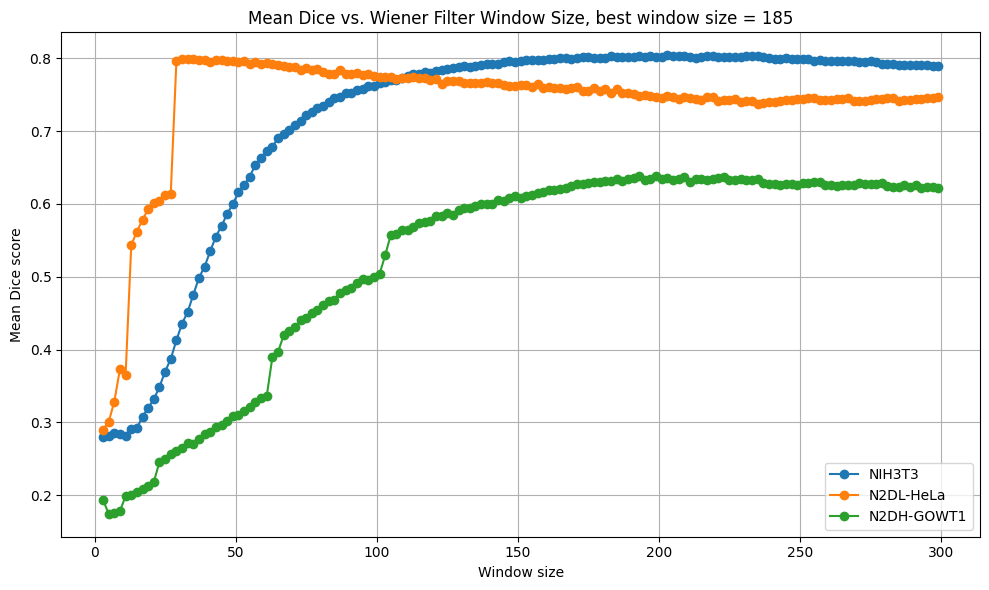

In [16]:
import os
import sys
import numpy as np
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from scipy.ndimage import uniform_filter

def find_best_window(all_means: np.ndarray,
                     window_sizes: Sequence[int]
                    ) -> Tuple[int, float]:
    """
    Finds the window size that maximizes the average Dice score across datasets.

    Args:
        all_means: 2D array of shape (num_window_sizes, num_datasets),
                   as returned by evaluate_datasets_mean_filter (rows = window sizes).
        window_sizes: 1D sequence of window sizes corresponding to the rows of all_means.

    Returns:
        best_window: the window size with the highest mean Dice score.
        best_score: the mean Dice score at best_window.
    """
    # compute mean across datasets for each window size (mean of each row)
    mean_across = np.mean(all_means, axis=1)
    # find the index of the maximum mean
    best_idx = int(np.argmax(mean_across))
    # map back to the window size
    best_window = window_sizes[best_idx]
    best_score = float(mean_across[best_idx])
    return best_window, best_score

all_mean = np.load("Dice_scores/all_datasets_dice_means_wienerfilter.npy")

best_window, best_mean_dice_score = find_best_window(all_mean, window_sizes=window_sizes)

# Optionally plot results
plt.figure(figsize=(10, 6))

for name in results:
    plt.plot(window_sizes, results[name], marker='o', label=name)
    
plt.xlabel('Window size')
plt.ylabel('Mean Dice score')
plt.title(f'Mean Dice vs. Wiener Filter Window Size, best window size = {best_window}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()